# BigBang Tutorial

Many Standards Development Organizations (SDOs) have working groups that organize themselves through mailing lists. This mailing list data is a valuable source of research insights but can be challenging to gather and analyze. BigBang is an open source toolkit for studying processes of open collaboration and deliberation via analysis of the communications records. Its tools for collecting, analyzing, and visualizing mailing list data are used by a community of information policy researchers to study participation trends and interaction in these settings. This tutorial is a hands-on introduction to the toolkit’s capabilities.


## Using this notebook

Pressing `Shift + Enter` with a cell selected executes the cell.

There are two types of cells.
 - Markdown cells (like this one) are written in Markdown and render to formatted text when ran.
 - Code cells are written in Python. Executing the cell executes the code and returns the output of the last line.

In the top menu, `Kernel > Restart & Run All` restarts the kernel and executes all of the cells.

First, make sure you have the correct dependencies installed by running:

```sh
pip install matplotlib seaborn
```

Execute the following cell to import a number of libraries (including BigBang) into the kernel memory.

In [2]:
from bigbang.archive import Archive
import bigbang.parse as parse
from bigbang.analysis.utils import extract_domain
import bigbang.analysis.graph as graph
import bigbang.ingress.mailman as mailman
import bigbang.analysis.process as process
from datetime import date
import networkx as nx
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz
import seaborn as sns

## Data Ingress

BigBang aims to make streamline the process of collecting data from SDOs.

Its most robust tools are built for collecting and process email records.

We will also demonstrate how data from other sources can be integrated into an analysis.

### Email

Many SDOs use mailing lists to support internal discussion by their working groups.
For example:

 - Internet Engineering Task Force (IETF)
 - World Wide Web Consortium (W3C)
 - Internet Corporation for Assigned Names and Numbers (ICANN)
 - 3rd Generation Partnership Project (3GPP)

Generally speaking, each working group is assigned its own mailing list, which is archived on the web.

Because email is itself a standard communication protocol, we can build standardized tools for collecting, processing, and visualizing this data.

Email data is stored for analysis in the `archives/` directory, in the directory of your BigBang installation.

You can collect other data using the the `bigbang` command line program.

```
$ bigbang --help
Usage: bigbang [OPTIONS] COMMAND [ARGS]...

  BigBang CLI tools

Options:
  --help  Show this message and exit.

Commands:
  collect-draft-metadata         Collects files from public mailing list...
  collect-git-from-file-of-urls  Load git data from repo URLs listed in a...
  collect-git-from-github-org    Load git data from repos in a GitHub...
  collect-git-from-url           Load git data from a repo URL
  collect-mail                   Collects files from public mailman...
```

For example, to collect data from the dtn-security, tls-reg-review, httpbisa, and v6ops mailing lists, you run this:

```sh
bigbang collect-mail --url https://www.ietf.org/mail-archive/text/dtn-security/
bigbang collect-mail --url https://www.ietf.org/mail-archive/text/tls-reg-review/
bigbang collect-mail --url https://www.ietf.org/mail-archive/text/httpbisa/
bigbang collect-mail --url https://www.ietf.org/mail-archive/text/v6ops/
```

Go ahead and run these commands in your shell to download these mailing lists.

### IETF Datatracker

One way to get original research results is to combine data from different sources.

IETF makes many other records besides its mailing lists available for inspection via a tool called the [IETF DataTracker](https://datatracker.ietf.org/).

BigBang integrates well with `ietfdata`, the Python wrapper for this data tracker developed by the University of Glasgow. You can find more information about `ietfdata` on [Github](https://github.com/glasgow-ipl/ietfdata).


### Ancillary Data

In addition to these data sources, BigBang comes with hand-curated data sets that have proven useful for data cleaning and research.

We discuss one of these datasets in the Organizations section, below.


## Analysis Tools

Now for the fun part! We can load some of the archives into Python and visualize some data!

The code below looks up data for working groups by name from the `archives/` directory and loads it into a Python object representation, and `Archive`.

In [3]:
mailing_lists = ["dtn-security", "tls-reg-review", "httpbisa", "v6ops"]
archives = [
    Archive(mailing_list, archive_dir="../archives") for mailing_list in mailing_lists
]

### Activity

By 'activity' we mean simply the number of emails sent to the mailing list over time, and by whom.

BigBang makes it easy to derive a record of activity counts from an email archive.

In [4]:
activities = [archive.get_activity() for archive in archives]

We can then plot the rolling average of activity on each mailing list over time.

<Axes: xlabel='Date'>

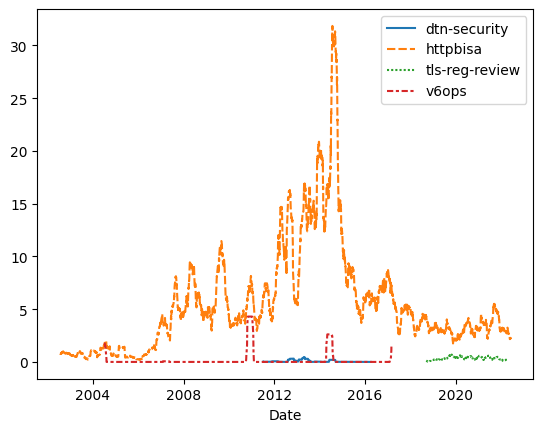

In [5]:
sum_activities = pd.DataFrame.from_records(
    {mailing_lists[i]: a.sum(1) for i, a in enumerate(activities)}
)
sum_activities.index = sum_activities.index.map(date.fromordinal)
window = 100

sns.lineplot(data=sum_activities.rolling(window).mean().dropna(how="all"))

The activity matrix is broken down by email sender. So we can manipulate the matrix and find the top senders over all time.

In [6]:
activities[1].sum().sort_values(ascending=False)[:15]

From
"Salz, Rich" <rsalz@akamai.com>                                     124.0
Yoav Nir <ynir.ietf@gmail.com>                                       79.0
Benjamin Kaduk <kaduk@mit.edu>                                       28.0
"Christopher Wood" <caw@heapingbits.net>                             18.0
Nick Sullivan <nick@cloudflare.com>                                  16.0
"Sabrina Tanamal via RT" <drafts-expert-review-comment@iana.org>     14.0
"Amanda Baber via RT" <iana-prot-param@iana.org>                     13.0
Sean Turner <sean@sn3rd.com>                                         12.0
"Amanda Baber via RT" <drafts-expert-review-comment@iana.org>        11.0
"Amanda Baber via RT" <iana-prot-param-comment@iana.org>             11.0
"Sabrina Tanamal via RT" <iana-prot-param@iana.org>                   9.0
Paul Yang <kaishen.yy@antfin.com>                                     8.0
"Olle E. Johansson" <oej@edvina.net>                                  7.0
Wang Haiguang <wang.haiguang.shie

Each activity matrix is a Pandas `DataFrame`, which supports a number of database-like operations.

Notice that in some cases the same person is indentified in by multiple different strings. This is extremely common, and BigBang contains some entity resolutions tools for combining these records.

One way to approach this problem is to aggregate messages by email domain. In this case, that would group all `@iana.org` messages together. We will see how this works later in this notebook.

### Word Trends

The body of a mailing list is most often text in natural language.

This means the data affords analysis using Natural Language Processing (NLP) techniques.

In this section of the tutorial, we will use a very simple NLP technique -- counting the number of appearances of a word.

To do this, we will need to install some additional data associated with the the Python Natural Language ToolKit `nltk`.

```sh
pip install nltk
```

In [7]:
### Maybe move this into a module loaded as a script to get it out of the way.

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("punkt")

from nltk.stem.lancaster import LancasterStemmer

st = LancasterStemmer()

import re


def count_word(text, word, stem=False):
    if not text:
        return 0

    if len(word.split(" ")) <= 1:
        ## normalize the text - remove apostrophe and punctuation, lower case
        normalized_text = re.sub(r"[^\w]", " ", text.replace("'", "")).lower()

        tokenized_text = nltk.tokenize.word_tokenize(normalized_text)

        if stem:
            tokenized_text = [st.stem(t) for t in tokenized_text]

        return tokenized_text.count(word)
    else:
        return text.lower().count(word)

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's pick a few significant words for analysis.

In [8]:
checkwords = ["security", "privacy", "header"]

In [9]:
archive_word_data = {}

In [10]:
for i, archive in enumerate(archives):
    data = archive.data.copy()
    dates = data["Date"].map(lambda x: x.date())
    data["Date"] = dates

    for word in checkwords:
        data[word] = data["Body"].apply(lambda x: count_word(x, word))

        archive_word_data[f"{mailing_lists[i]} {word}"] = data.groupby("Date")[
            word
        ].sum()

word_data = pd.DataFrame(archive_word_data)

In [11]:
new_date_range = pd.date_range(
    start=word_data.index.min(), end=word_data.index.max(), freq="D"
)
word_data = word_data.reindex(new_date_range, fill_value=0)
word_data = word_data.fillna(0)

<Axes: >

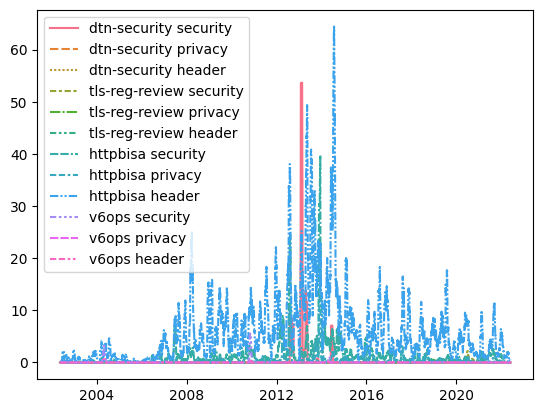

In [12]:
window = 30

sns.lineplot(data=word_data.rolling(window).mean().dropna(how="all"))

This plot is pretty messy! Can you clean it up?

 - You can change the mailing lists being plotting by changing the value of `mls` in cell `[3]`.
 - Can you figure out how to normalize the word counts by the activity counts? This may require some Python skills. If you can't do it, try asking your neighbor.

## Interactions

Email messages are always 'From' somebody. In a mailing list, they are always 'To' the mailing list itself -- all subscribers recieve the email. But some emails are 'In-Reply-To' other emails.

We define an 'interaction graph' in terms of these replies.

Consider a network with nodes representing all people who have sent emails to the mailing list.

We create an edge from A to B if A replies to an email from B. We weight the edge by the number of times A replies to B. 

We are providing a method for visualizing these graphs. Note that we only include nodes for people who have sent a number of messages over a threshold (15% of the maximum number of messages sent by anybody to the list). That makes the visualizations much cleaner!

In [13]:
def draw_interaction_graph(ig, threshold=0.15):
    ig = ig.copy()
    max_sent = max([data["sent"] for name, data in ig.nodes(data=True)])
    ig.remove_nodes_from(
        [
            name
            for name, data in ig.nodes(data=True)
            if data["sent"] < threshold * max_sent
        ]
    )

    edges, weights = zip(*nx.get_edge_attributes(ig, "weight").items())
    weights_multiplier = 50.0 / max(weights)
    weights = [w * weights_multiplier for w in weights]

    pos = nx.shell_layout(ig)

    node_size_multiplier = 1000 / max(
        [data["sent"] for name, data in ig.nodes(data=True)]
    )
    node_size = [
        data["sent"] * node_size_multiplier for name, data in ig.nodes(data=True)
    ]

    nx.draw(
        ig,
        pos,
        with_labels=False,
        node_size=node_size,
        node_color="#CCCCFF",
        alpha=0.8,
        font_size=12,
        # font_weight='bold',
        edgelist=edges,
        width=weights,
        edge_color=weights,
        edge_cmap=plt.cm.viridis,
    )

    # some math labels
    labels = {node: str(node)[:15] for node in ig.nodes}
    nx.draw_networkx_labels(ig, pos, labels, font_size=12)

You can change the way the visualization looks by altering the values in the `draw_interaction_graph` function.

Next, we will use this function to plot the mailing lists.

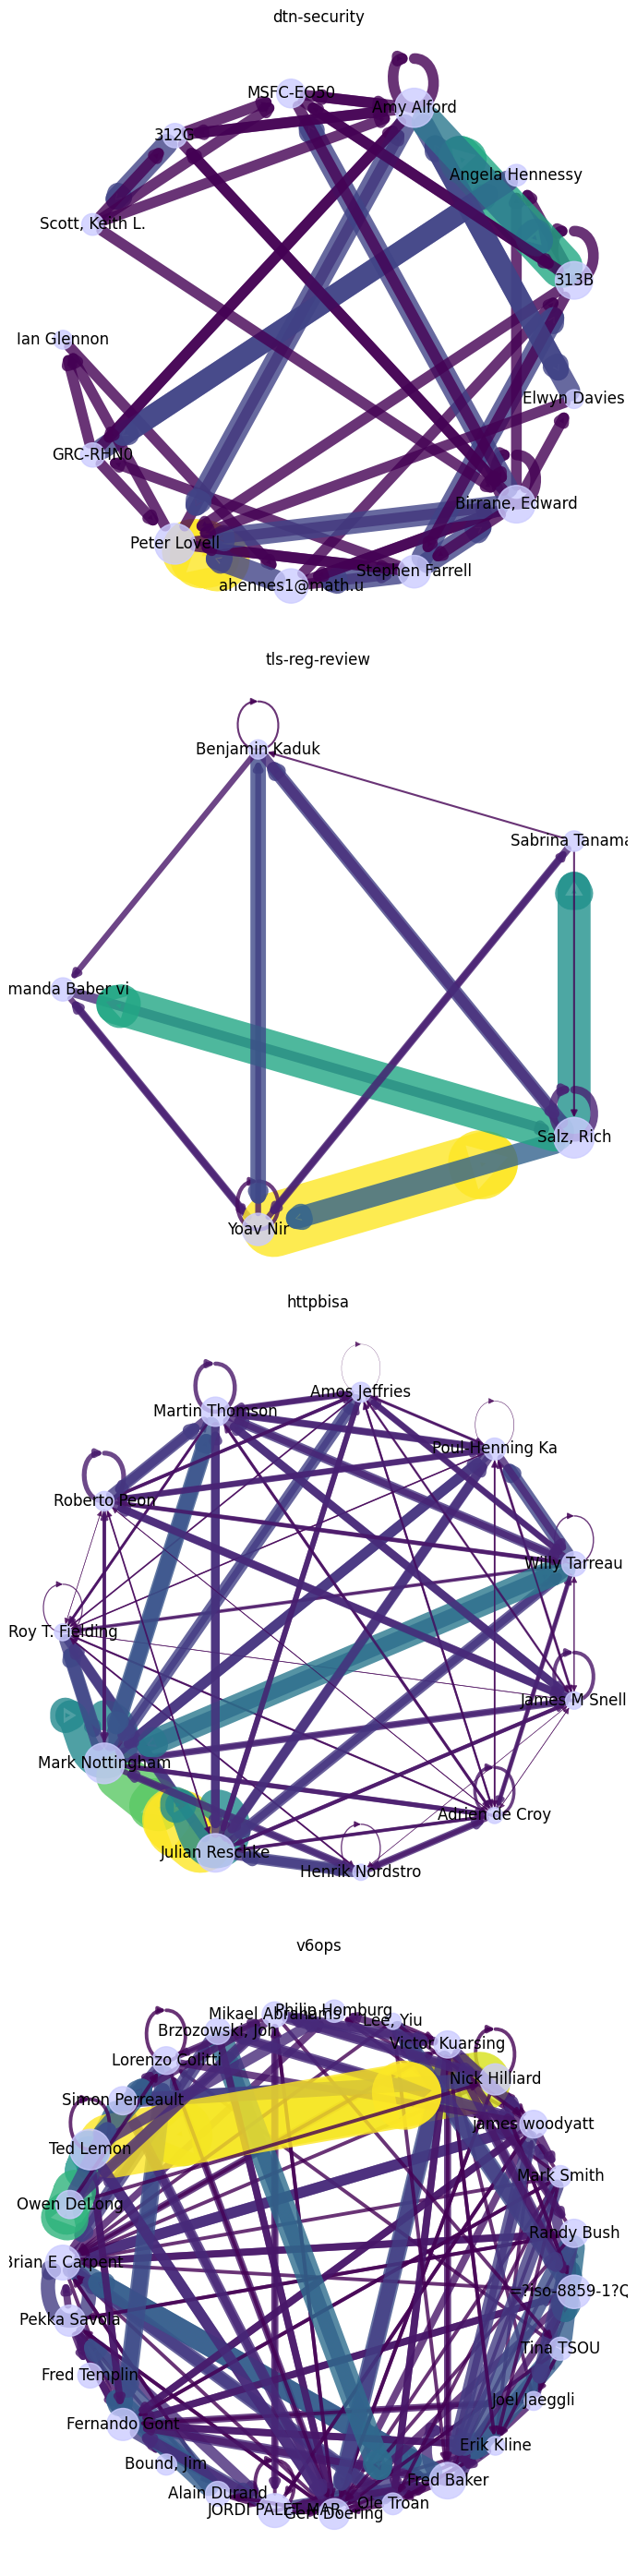

In [17]:
figdim = len(archives) * 100 + 10

plt.figure(figdim, figsize=(7, 28))
for i, arx in enumerate(archives):
    plt.subplot(figdim + i + 1)  # create a subplot keyed to the index of this ml
    plt.title(mailing_lists[i])
    df = arx.data.copy()
    ig = graph.messages_to_interaction_graph(df)
    draw_interaction_graph(ig)

plt.tight_layout()
plt.show()

### Email domains

Many researchers aren't as interested in the individual participants in an SDO working group as they are in which organizations are involved.

Matching emails to organization of origin is a complex task, but a relatively simple first step is to aggregate the emails by the email **domain**. For example, the email address **abc123@nyu.edu** has the domain **nyu.edu**, which indicates that the email comes from a particular university.

In the plots below, how many of the email domains do you recognize?

Are there any surprises?

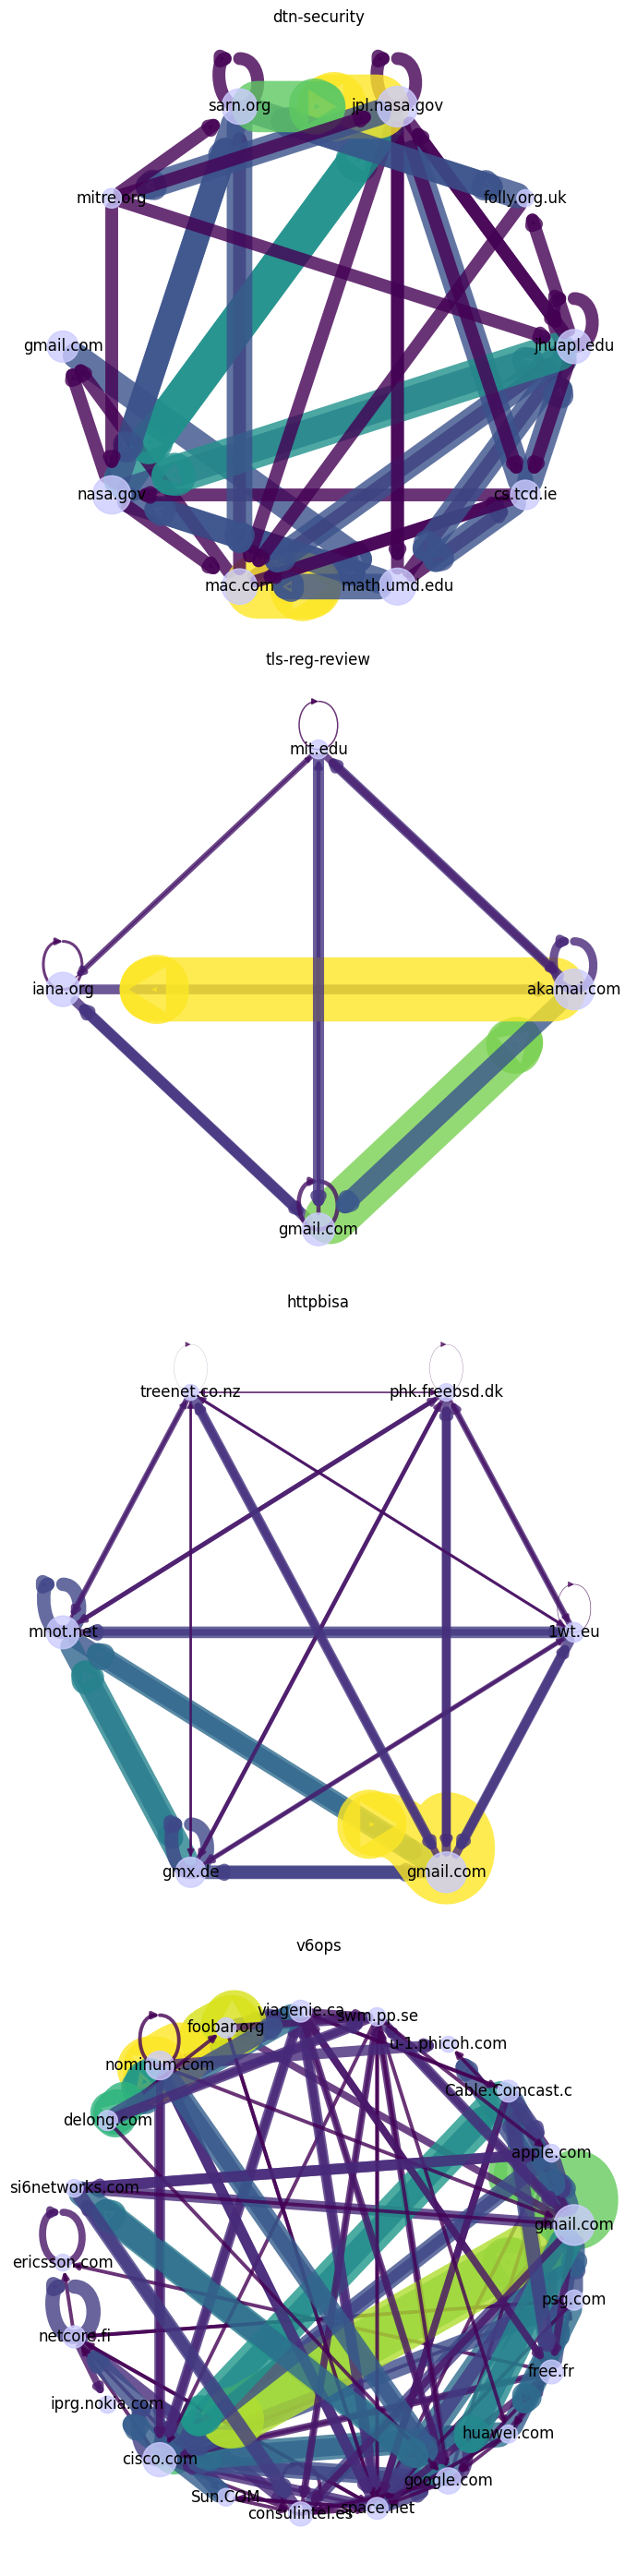

In [19]:
figdim = len(archives) * 100 + 10

plt.figure(figdim, figsize=(7, 28))
for i, archive in enumerate(archives):
    plt.subplot(figdim + i + 1)  # create a subplot keyed to the index of this ml
    plt.title(mailing_lists[i])
    df = archive.data.copy()

    ## could make this cleaner -- move more to the library
    df["domain"] = df["From"].map(extract_domain)
    df["From"] = df["domain"]
    df = df.dropna(subset="From")

    ig = graph.messages_to_interaction_graph(df, clean=False)
    draw_interaction_graph(ig)

plt.tight_layout()
plt.show()

### Organizations

We have been building a database of Organization metadata.

This would, among other things, allow us to match emails with there organization of origin through, for example, the email domain.

We show the current state of the data, and how to access it, below.

In [20]:
import bigbang.datasets.organizations as organizations

org_data = organizations.load_data()

In [21]:
org_data.head()

,name,category,subsidiary of / alias of,stakeholdergroup,nationality,email domain names,Membership Organization,Wiki Page
0,Universidad Tecnológica Nacional,Research Institution,NaN,Academia,Argentina,NaN,NaN,NaN
1,Attorney-General's Department Australian Gove...,NaN,NaN,Government,Australia,NaN,ETSI,NaN
2,COMMUNICATIONS ALLIANCE LTD,Association,NaN,Business,Australia,NaN,OTHER,NaN
3,Softel Systems Pty Ltd,Cybersecurity,NaN,Business,Australia,softelsystems.com.au,ETSI,NaN
4,Telstra Corporation Limited,Telecommunications Provider,NaN,Business,Australia,team.telstra.com,ETSI,NaN


### Gender

Many researchers are interested in the gender composition of SDO working groups.

We have integrated a Python library for detecting gender based on people's first names -- [gender-detector](https://pypi.org/project/gender-detector/).

While the merits of this method of determining participant gender are subject to a great deal of debate, we demonstrate below how to conduct a preliminery analysis of gender participation in mailing lists.

First, install it by running:
```
pip install gender_detector
```

In [22]:
from gender_detector import gender_detector as gd

The detector will try to determine if a name is **male** or **female** based on census records. If the detection database does not contain the queried name, we will say the name is unknown -- **n-unknown**. If the name is too ambiguously gendered to make a definitive call, we will say the name is **g-unknown**.

In [24]:
detector = gd.GenderDetector("us")

gender_ambiguous_names = {}


def guess_gender(name):
    if not name:
        return "n-unknown"
    try:
        if detector.guess(name) == "unknown":
            return "g-unknown"

        return detector.guess(name)
    except:
        return "error"


series = []
for i, archive in enumerate(archives):
    activity = Archive.get_activity(archive).sum(0)
    activityFrame = pd.DataFrame(activity, columns=["Message Count"])

    activityFrame["Name"] = activityFrame.index.map(lambda x: parse.clean_from(x))
    activityFrame["First Name"] = activityFrame["Name"].map(
        lambda x: parse.guess_first_name(x)
    )
    activityFrame["Guessed Gender"] = activityFrame["First Name"].map(guess_gender)

    counts = activityFrame.groupby("Guessed Gender")["Message Count"].count()
    counts["name"] = mailing_lists[i]
    series.append(counts)

gender_data = pd.DataFrame.from_records(series, index="name").transpose()

In [25]:
gender_data

name,dtn-security,tls-reg-review,httpbisa,v6ops
Guessed Gender,,,,
female,2.0,3.0,62.0,6.0
g-unknown,3.0,3.0,416.0,36.0
male,9.0,35.0,866.0,92.0
n-unknown,15.0,25.0,405.0,41.0
error,NaN,2.0,7.0,NaN


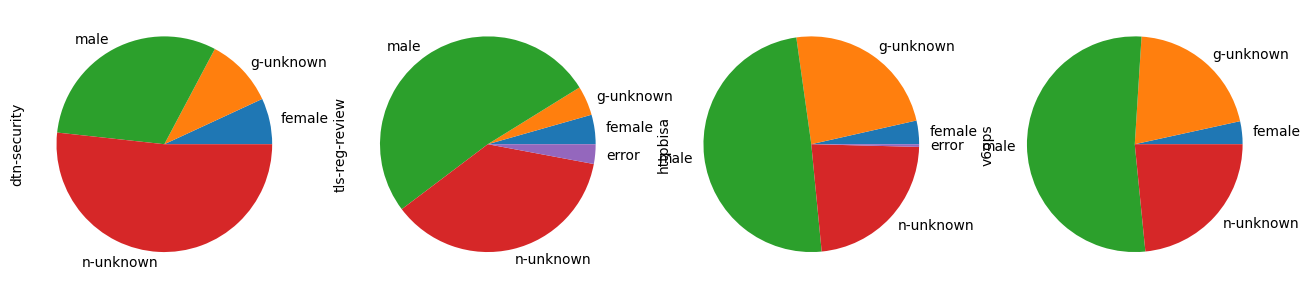

In [26]:
figure, axes = plt.subplots(ncols=len(archives), figsize=(16, 4))

for i, archive in enumerate(archives):
    # plt.subplot(figdim + i + 1) # create a subplot keyed to the index of this ml
    gender_data.plot(kind="pie", y=mailing_lists[i], ax=axes[i])
    axes[i].get_legend().remove()

## What's next?

BigBang comes with many more notebooks, like this one, demonstrating other ways to use it.

These are in the `examples/` directory where you installed BigBang.

You can also experiment with modifying the scripts in this notebook to find other insights.

Because all the software used is open source, it is easy to look up how any particular software package, such as Matplotlib or Pandas, works -- just Google it!

You can also think about how to operationalize a research question using BigBang. If you have completed the tutorial materials in this notebook, feel free to ask about your research interest in the workshop!